In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import matplotlib.pyplot as plt
from utils import create_directory, plot_simulations, plot_training_log
import json

In [2]:
import motornet as mn
from task import CentreOutFF
from policy import Policy
import torch as th
import numpy as np

In [3]:
data_dir = create_directory('2023-10-02')
model_num = 2

weight_file = os.path.join(data_dir, f"model{model_num}_weights")
log_file = os.path.join(data_dir, f"model{model_num}_log.json")
cfg_file = os.path.join(data_dir, f"model{model_num}_cfg.json")

Directory '/Users/mahdiyarshahbazi/Documents/Data/2023-10-02' already exists.


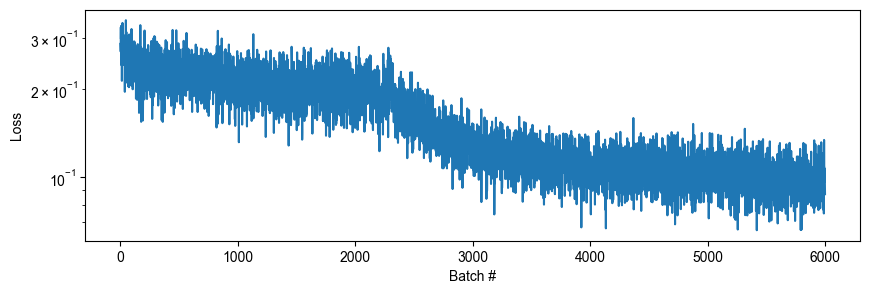

In [4]:
# retrieve and plot training history
with open(log_file, 'r') as file:
    loaded_training_log = json.load(file)

fig = plt.figure(figsize=(10,3))
plt.rcParams['font.family'] = "Arial"
ax = plot_training_log(log=loaded_training_log)
fig.savefig(data_dir+f'/model{model_num}_loss.pdf',bbox_inches='tight')

In [5]:
# test model

#hidden_noise         = 1e-3
#proprioception_noise = 1e-3,
#vision_noise         = 1e-4,
#vision_delay         = 0.05,
#proprioception_delay = 0.02,
#action_noise  = 1e-4,

# load configuration
with open(cfg_file,'r') as file:
    cfg = json.load(file)

# effector
muscle_name = cfg['effector']['muscle']['name']
timestep = cfg['effector']['dt']
muscle = getattr(mn.muscle,muscle_name)()
effector = mn.effector.RigidTendonArm26(muscle=muscle) #,timestep=timestep

# delay
proprioception_delay = cfg['proprioception_delay']*cfg['dt']
vision_delay = cfg['vision_delay']*cfg['dt']

# noise
action_noise = cfg['action_noise'][0]
proprioception_noise = cfg['proprioception_noise'][0]
vision_noise = cfg['vision_noise'][0]

# force-field
# ff_coefficient = cfg['ff_coefficient']

# initialize environment
max_ep_duration = cfg['max_ep_duration']
env = CentreOutFF(effector=effector,max_ep_duration=max_ep_duration,name=cfg['name'],
                  action_noise=action_noise,proprioception_noise=proprioception_noise,
                  vision_noise=vision_noise,proprioception_delay=proprioception_delay,
                  vision_delay=vision_delay)

# initialize policy
device = th.device("cpu")
policy = Policy(env.observation_space.shape[0], 32, env.n_muscles, device=device)
policy.load_state_dict(th.load(weight_file))

<All keys matched successfully>

In [24]:
from pathlib import Path
data_dir

directory_list = [directory for directory in Path(data_dir).glob('model*_w*t*') if directory.is_file()]


In [25]:
directory_list

[PosixPath('/Users/mahdiyarshahbazi/Documents/Data/2023-10-02/model1_weights'),
 PosixPath('/Users/mahdiyarshahbazi/Documents/Data/2023-10-02/model2_weights')]

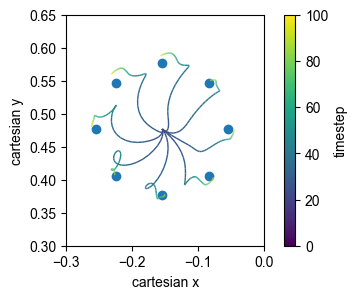

In [9]:
# Evaluation
batch_size = 8
# initialize batch

endpoint_load = th.from_numpy(np.repeat(np.expand_dims(np.array([0, 0]), axis=0),batch_size, axis=0))
FF_matvel = th.tensor([[0, -0], [0, 0]], dtype=th.float32)

obs, info = env.reset(condition ="test",catch_trial_perc=0,options={'batch_size':batch_size},ff_coefficient=8)

h = policy.init_hidden(batch_size=batch_size)
terminated = False

# initial positions and targets
xy = [info["states"]["fingertip"][:, None, :]]
tg = [info["goal"][:, None, :]]

# simulate whole episode
while not terminated:  # will run until `max_ep_duration` is reached
  action, h = policy(obs, h)

  obs, reward, terminated, truncated, info = env.step(action=action)
  
  vel = info["states"]["cartesian"][:,2:]
  endpoint_load = vel@FF_matvel.T
  
  xy.append(info["states"]["fingertip"][:,None,:])  # trajectories
  tg.append(info["goal"][:,None,:])  # targets

# concatenate into a (batch_size, n_timesteps, xy) tensor
xy = th.detach(th.cat(xy, axis=1))
tg = th.detach(th.cat(tg, axis=1))
plot_simulations(xy=xy, target_xy=tg)